In [12]:
import torch
import torch.nn as nn
import numpy as np

import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
data = sns.load_dataset('iris')

In [14]:
df = torch.tensor(data.drop(columns="species").values).float()
labels = torch.zeros(len(df), dtype=torch.long)
labels[data.species == 'versicolor'] = 1 
labels[data.species == 'virginica'] = 2

In [15]:
class ann(nn.Module):
    def __init__(self, nunits, nlayers):
        super().__init__()
        # ModuleDict() is specifically designed to store layers in a deep learning network
        self.layers = nn.ModuleDict()
        self.nlayers = nlayers
        # input unit
        self.layers['input'] = nn.Linear(4, nunits)
        # hidden layers
        for i in range(nlayers):
            self.layers[f'layer{i}'] = nn.Linear(nunits, nunits)
        # output layer
        self.layers['output'] = nn.Linear(nunits, 3)

    def forward(self, x):
        # input layer
        x = self.layers['input'](x)
        # hidden layer
        for i in range(self.nlayers):
            x = F.relu(self.layers[f'layer{i}'](x))
        # output
        x = self.layers['output'](x)
        return x

In [16]:
nunits = 12
nlayers = 4
net = ann(nunits, nlayers)

In [17]:
net

ann(
  (layers): ModuleDict(
    (input): Linear(in_features=4, out_features=12, bias=True)
    (layer0): Linear(in_features=12, out_features=12, bias=True)
    (layer1): Linear(in_features=12, out_features=12, bias=True)
    (layer2): Linear(in_features=12, out_features=12, bias=True)
    (layer3): Linear(in_features=12, out_features=12, bias=True)
    (output): Linear(in_features=12, out_features=3, bias=True)
  )
)

In [19]:
from torchsummary import summary
summary(net, (150,4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 150, 12]              60
            Linear-2              [-1, 150, 12]             156
            Linear-3              [-1, 150, 12]             156
            Linear-4              [-1, 150, 12]             156
            Linear-5              [-1, 150, 12]             156
            Linear-6               [-1, 150, 3]              39
Total params: 723
Trainable params: 723
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


In [20]:
# testing the model with random data
tempx = torch.randn(5, 4)
y = net(tempx)
print(y.shape)
print(y)

torch.Size([5, 3])
tensor([[ 0.1688, -0.0105, -0.1830],
        [ 0.1698, -0.0096, -0.1903],
        [ 0.1659, -0.0106, -0.1803],
        [ 0.1627, -0.0106, -0.1750],
        [ 0.1693, -0.0104, -0.1877]], grad_fn=<AddmmBackward0>)


In [21]:
def train(model, epochs, x, y):
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    for i in range(epochs):
        # forward pass
        yhat = model(x)
        # compute loss
        loss = loss_function(yhat, y)     
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # final forward pass
    preds = model(x)
    predlabels = torch.argmax(preds, axis=1)
    totalacc = 100*torch.mean((predlabels==labels).float())
    return totalacc

In [22]:
train(net, 1000, df, labels)

tensor(97.3333)

# Experiment

In [39]:
num_layers = range(1,6)
num_units = np.arange(4,101,3)
num_epochs = 500

In [40]:
accuracies = np.zeros((len(num_units), len(num_layers)))

In [41]:
for i in range(len(num_units)):
    for j in range(len(num_layers)):
        net = ann(i, j)
        accuracies[i, j] = train(net, num_epochs, df, labels)
        

d:\repos\.udemy\lib\site-packages\torch\nn\init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [42]:
accuracies

array([[33.33333588, 33.33333588, 33.33333588, 33.33333588, 33.33333588],
       [70.        , 33.33333588, 66.66667175, 33.33333588, 33.33333588],
       [91.33333588, 24.        , 33.33333588, 33.33333588, 33.33333588],
       [77.33332825, 71.33332825, 92.        , 33.33333588, 33.33333588],
       [95.33332825, 68.        , 35.33333206, 68.66666412, 33.33333588],
       [97.33333588, 68.        , 95.33332825, 33.33333588, 33.33333588],
       [96.66666412, 93.33333588, 66.66667175, 66.66667175, 66.        ],
       [97.33333588, 94.66666412, 90.66667175, 46.        , 33.33333588],
       [96.66666412, 97.33333588, 96.        , 66.66667175, 68.66666412],
       [96.        , 97.33333588, 92.66666412, 73.33333588, 33.33333588],
       [95.33332825, 96.66666412, 90.66667175, 63.33333206, 33.33333588],
       [97.33333588, 96.66666412, 94.66666412, 66.66667175, 33.33333588],
       [98.        , 96.66666412, 97.33333588, 66.66667175, 58.66666412],
       [98.        , 96.66666412, 92. 

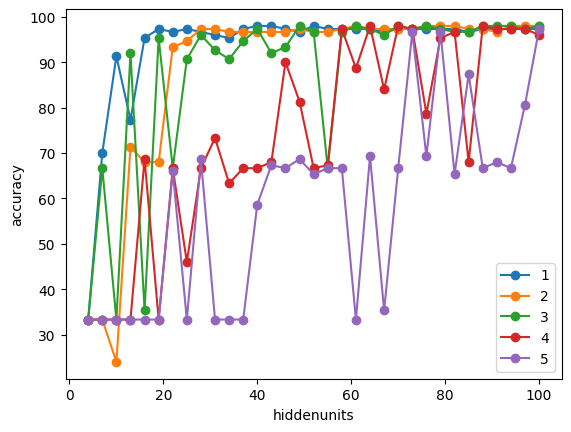

In [43]:
plt.plot(num_units, accuracies, 'o-')
plt.ylabel('accuracy')
plt.xlabel('hiddenunits')
plt.legend(num_layers)

#### Shallow models tend to do better than deep models on small datasets

#### In general wider networks are better than deeper networks because the wider networks have more parameters to learn from. However, the wider networks are more prone to overfitting. The deeper networks are better at generalizing but they are more prone to vanishing gradient problem. So, the best approach is to use a combination of both wider and deeper networks